# Object masks in images from prompts with AutoSAM

Based on AutoSAM annotation.py

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/image_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [ ]:
using_colab = True

In [ ]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
if using_colab:
    !{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/Iris-Song/AutoSAM.git'
!git clone tps://github.com/Iris-Song/AutoSAM.git


PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/Iris-Song/AutoSAM.git to /tmp/pip-req-build-je1qzfvr
  Running command git clone --filter=blob:none --quiet https://github.com/Iris-Song/AutoSAM.git /tmp/pip-req-build-je1qzfvr
  Resolved https://github.com/Iris-Song/AutoSAM.git to commit 15e6944167c65295bb0b1c7d43735c19e3b03f3a
  Preparing metadata (setup.py) ... done
Cloning into 'AutoSAM'...
git: 'remote-tps' is not a git command. See 'git --help'.

The most similar command is
	remote-ftps


## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import os

# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pycocotools.coco import COCO
from skimage.draw import polygon
from segment_anything import sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [ ]:
np.random.seed(3)


def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    print(mask.shape)
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


def show_masks(image, masks, scores=None, point_coords=None, box_coords=None, input_labels=None, borders=True):
    if not scores:
        scores = [None for _ in masks]
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1 and scores[0]:
            plt.title(f"Mask {i + 1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

First, load the SAM 2 model and predictor. Change the path below to point to the SAM 2 checkpoint. Running on CUDA and using the default model are recommended for best results.

# AutoSAM for dataset

## Selecting objects with AutoSAM

Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction.

In [ ]:
if using_colab:
    from google.colab import drive
    
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
# Set the directory paths
train_dir = '/content/drive/MyDrive/CV/project/archive/train'
test_dir = '/content/drive/MyDrive/CV/project/archive/test'
val_dir = '/content/drive/MyDrive/CV/project/archive/valid'

train_annotation_file = '/content/drive/MyDrive/CV/project/archive/train/_annotations.coco.json'
test_annotation_file = '/content/drive/MyDrive/CV/project/archive/test/_annotations.coco.json'
val_annotation_file = '/content/drive/MyDrive/CV/project/archive/valid/_annotations.coco.json'

# Load COCO annotations
coco_train = COCO(train_annotation_file)
coco_test = COCO(test_annotation_file)
coco_val = COCO(val_annotation_file)


# Function to create binary masks from COCO annotations
def create_mask(image_id, coco, height, width):
    coords = []
    mask = np.zeros((height, width), dtype=np.uint8)
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)
    for annotation in annotations:
        for seg in annotation['segmentation']:
            poly = np.array(seg).reshape((int(len(seg) / 2), 2))
            rr, cc = polygon(poly[:, 1], poly[:, 0], (height, width))
            mask[rr, cc] = 1
            cd = np.mean(poly, axis=0)
            coords.append(cd)
    # print(coords)
    middle_coord = np.mean(coords, axis=0)
    # print(coords, middle_coord)
    return mask, middle_coord


# Function to load images and masks
def load_images_and_masks(data_dir, coco, img_height=256, img_width=256):
    image_list = []
    mask_list = []
    coord_list = []
    img_ids = coco.getImgIds()
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(data_dir, img_info['file_name'])
        img = Image.open(img_path)
        img = np.array(img.convert("RGB"))
        if img is not None:
            # img = cv2.resize(img, (img_width, img_height))
            # img = img / 255.0  # Normalize to [0, 1]
            mask, coord = create_mask(img_id, coco, img_info['height'], img_info['width'])
            # mask = cv2.resize(mask, (img_width, img_height))
            mask = np.expand_dims(mask, axis=-1)
            image_list.append(img)
            mask_list.append(mask)
            coord_list.append(coord)
    return np.array(image_list), np.array(mask_list), np.array(coord_list)


# Load datasets
# X_train, Y_train = load_images_and_masks(train_dir, coco_train)
# X_val, Y_val = load_images_and_masks(val_dir, coco_val)
X_test, Y_test, coord_test = load_images_and_masks(test_dir, coco_test)

# Ensure masks are binary
# Y_train[Y_train > 0.5] = 1
# Y_train[Y_train <= 0.5] = 0

# Y_val[Y_val > 0.5] = 1
# Y_val[Y_val <= 0.5] = 0

Y_test[Y_test > 0.5] = 1
Y_test[Y_test <= 0.5] = 0

# # Images and ground truth masks for training set
# images_train = X_train
# ground_truth_masks_train = Y_train

# Images and ground truth masks for validation set
# images_val = X_val
# ground_truth_masks_val = Y_val

# Images and ground truth masks for test set
images_test = X_test
ground_truth_masks_test = Y_test

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Display GroundTruth Example

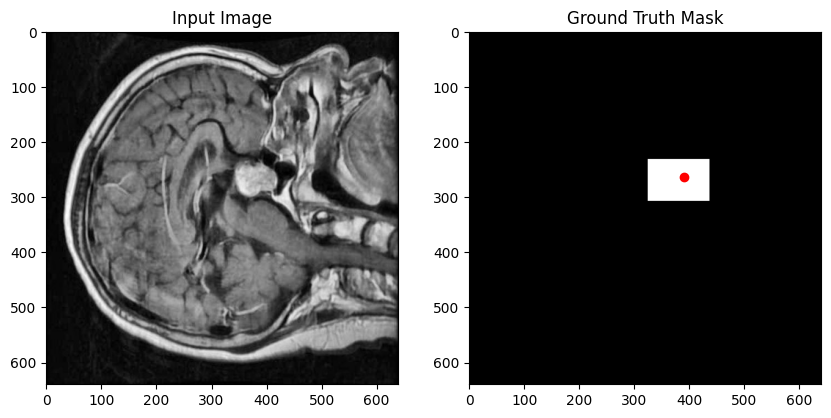

In [ ]:
# Example: Displaying an image and its corresponding ground truth mask, and coord to find the mask
plt.figure(figsize=(10, 5))

# Display an image
plt.subplot(1, 2, 1)
plt.imshow(images_test[0])
plt.title('Input Image')

# Display its corresponding ground truth mask
plt.subplot(1, 2, 2)
plt.imshow(ground_truth_masks_test[0].squeeze(), cmap='gray')
plt.scatter(coord_test[0][0], coord_test[1][0], color='red', label=f'Point ({coord_test[0][0]}, {coord_test[1][0]})')
plt.title('Ground Truth Mask')

plt.show()

## Display AutoSam example

In [ ]:
def sam_call(image, sam, points, original_size, device):
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
    image_tensor = transform.apply_image_torch(image_tensor)
    input_images = transform.preprocess(image_tensor).unsqueeze(dim=0).to(device)
    with torch.no_grad():
        image_embeddings = sam.image_encoder(input_images)
        point_coords = transform.apply_coords(np.array(points), original_size)
        coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=device).unsqueeze(dim=0)
        labels_torch = torch.as_tensor([1], dtype=torch.int, device=device)
        coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
        points = (coords_torch, labels_torch)
        sparse_embeddings, dense_embeddings_none = sam.prompt_encoder(points=points, boxes=None, masks=None)
        low_res_masks, iou_predictions = sam.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings_none,
            multimask_output=False,
        )
    return low_res_masks, image_tensor


def segment_image(image, point, sam, device):
    original_size = image.shape[:2]
    mask, image_tensor = sam_call(image, sam, point, original_size, device)
    input_size = image_tensor.shape[1:]
    mask = sam.postprocess_masks(mask, input_size=input_size, original_size=original_size)
    mask = mask.squeeze().cpu().numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    # Convert to binary mask
    binary_mask = (mask > 0.5).astype(np.uint8)
    return binary_mask


sam_args = {
    'sam_checkpoint': "/content/drive/MyDrive/CV/project/sam_vit_b.pth",
    'model_type': "vit_b",
    'generator_args': {
        'points_per_side': 8,
        'pred_iou_thresh': 0.95,
        'stability_score_thresh': 0.7,
        'crop_n_layers': 0,
        'crop_n_points_downscale_factor': 2,
        'min_mask_region_area': 0,
        'point_grids': None,
        'box_nms_thresh': 0.7,
    },
    'gpu_id': 0,
}


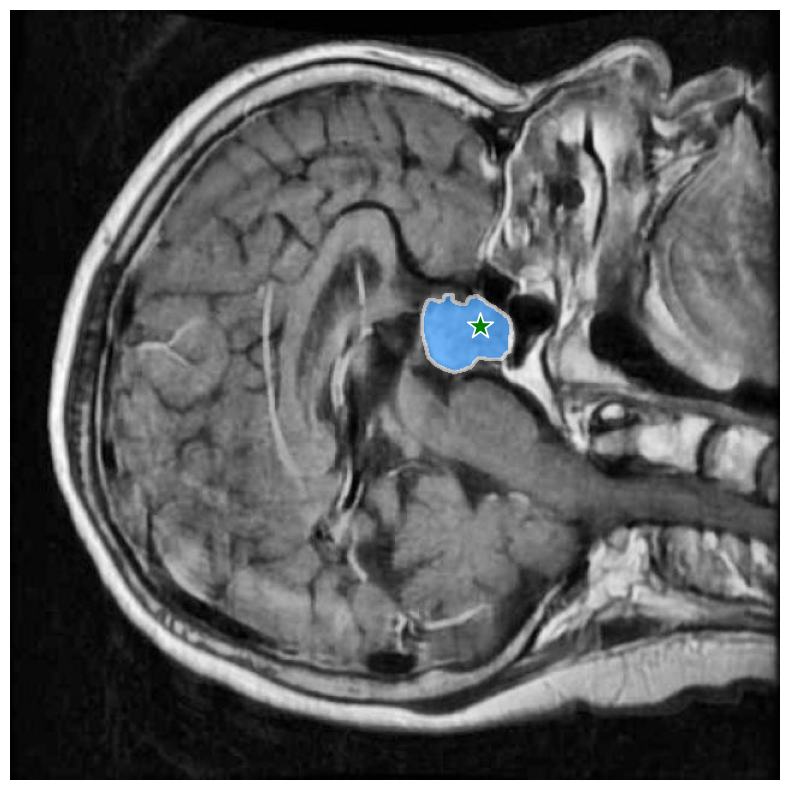

In [ ]:
example_image = images_test[0]
example_coord = coord_test[0]
input_point = np.array([example_coord])
input_label = np.array([1])

sam = sam_model_registry[sam_args['model_type']](checkpoint=sam_args['sam_checkpoint'])
sam.to(device=device)

transform = ResizeLongestSide(1024)
mask = segment_image(example_image, example_coord, sam, device)

show_masks(example_image, [mask], point_coords=input_point, input_labels=input_label, borders=True)

In [ ]:
# Assuming you have a list of ground truth masks and images
ground_truth_masks = ground_truth_masks_test  # List or tensor of ground truth masks
images = images_test  # List or tensor of input images
coord = coord_test

# Predict masks using the AutoSAM
sam = sam_model_registry[sam_args['model_type']](checkpoint=sam_args['sam_checkpoint'])
sam.to(device=device)
transform = ResizeLongestSide(1024)

predicted_masks = []
i = 0
for image, point in zip(images, coord):
    if i % 10 == 0:
        print(f"now process image {i}")
    mask = segment_image(image, point, sam, device)
    predicted_masks.append(mask)
    i += 1


# Function to calculate IoU between two masks
def calculate_iou(pred_mask, gt_mask):
    # Convert to binary mask (if needed)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Ensure the ground truth mask is binary and 2D
    gt_mask = gt_mask.squeeze()  # Remove extra dimensions

    # Now calculate IoU
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else 0


# Calculate IoU for each image in the batch
batch_ious = []
for pred_mask, gt_mask in zip(predicted_masks, ground_truth_masks):
    # print(pred_mask.shape)
    # print(gt_mask.shape)
    iou = calculate_iou(pred_mask, gt_mask)
    batch_ious.append(iou)

# Average IoU for the batch
average_iou = np.mean(batch_ious)
print(f"Average IoU: {average_iou:.4f}")

now process image 0
now process image 10
now process image 20
now process image 30
now process image 40
now process image 50
now process image 60
now process image 70
now process image 80
now process image 90
now process image 100
now process image 110
now process image 120
now process image 130
now process image 140
now process image 150
now process image 160
now process image 170
now process image 180
now process image 190
now process image 200
now process image 210
Average IoU: 0.3162
